# Training time series ML Model on SageMaker to Forecast Volume

When you want to have a good VWAP (volume weighted average price), you need to have a good forecast of volume. This example demonstrates how to load historical minute bar data and train an DeepAR model on SageMaker to forecast volume. The procedure is as follows:

##### 1. Load Data from S3 and Prepare Data

Load the data from S3 and set volume as the target.

##### 2. Divide Data into Training and Validation Sets

Divide the data into training and validation datasets.

##### 3. Train SageMaker Built-in DeepAR Model

Pass the training and validation data to train the SageMaker built-in DeepAR model.

##### 3.2. (optional) Optimize the DeepAR Hyper-parameters 

You can use HPO (Hyper-parameter optimization) in Sagemaker to find the best Hyper-parameter value.

##### 4. Deploy the Model

Deploy the trained model for inference or further evaluation.

## Preparation

In [102]:
!pip install ta

In [123]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.inputs import TrainingInput
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.tuner import IntegerParameter, CategoricalParameter, HyperparameterTuner

import boto3
import pandas as pd
from io import StringIO
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime, timedelta
import ta

## Import and prepare training data

In [104]:
# Set up SageMaker session
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

role = get_execution_role()
prefix = 'deepar-ULVR'

In [105]:
# Set up S3 client
s3 = boto3.client('s3')

# Specify your bucket and file details
bucket_name = 'Your market data bucket'
file_key = 'minutebars.csv'  

# Read the file from S3
obj = s3.get_object(Bucket=bucket_name, Key=file_key)
data = obj['Body'].read().decode('utf-8')

# Convert to DataFrame
df = pd.read_csv(StringIO(data))
df = df[(df['volume'] != 0) & (df['close'] != 0) & (df['twap'] != 0)]

# Drop NaN values
df.dropna(inplace=True)

# Convert timestamp to datetime
df['timestamp']  = pd.to_datetime(df['bucket'])

df

,ticker,bucket,trades,open,high,low,close,volume,vwap,twap,timestamp
0,AAL.L,2024-07-01 07:00:00,46,2401.0,2431.5,2401.0,2423.0,72859,2402.990063,2425.252569,2024-07-01 07:00:00
1,AAL.L,2024-07-01 07:01:00,128,2425.0,2429.5,2420.0,2425.5,12212,2425.881387,2425.991103,2024-07-01 07:01:00
2,AAL.L,2024-07-01 07:02:00,19,2427.5,2427.5,2416.5,2416.5,1546,2418.197930,2423.425674,2024-07-01 07:02:00
3,AAL.L,2024-07-01 07:03:00,83,2418.0,2418.5,2410.5,2416.0,8590,2414.251397,2415.928137,2024-07-01 07:03:00
4,AAL.L,2024-07-01 07:04:00,90,2419.0,2419.0,2412.0,2412.5,10772,2415.266153,2415.349853,2024-07-01 07:04:00
...,...,...,...,...,...,...,...,...,...,...,...
1005547,ULVR.L,2024-07-31 15:27:00,23,4770.0,4772.0,4770.0,4772.0,6003,4770.818591,4770.872757,2024-07-31 15:27:00
1005548,ULVR.L,2024-07-31 15:28:00,44,4772.0,4772.0,4771.0,4771.0,12895,4771.427065,4771.326630,2024-07-31 15:28:00
1005549,ULVR.L,2024-07-31 15:29:00,47,4771.0,4772.0,4770.0,4771.0,12730,4770.804399,4770.806618,2024-07-31 15:29:00
1005555,ULVR.L,2024-07-31 15:35:00,4,4776.0,4776.0,4776.0,4776.0,2109582,4776.000000,4776.000000,2024-07-31 15:35:00


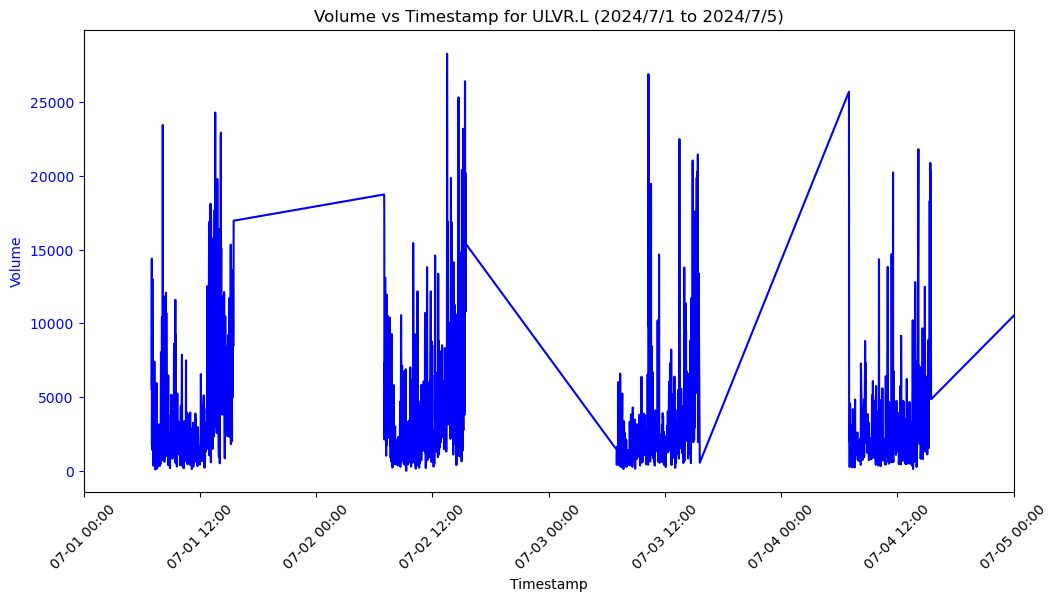

In [116]:
# Filter by time
ULVR = df[df['ticker'] == 'ULVR.L']

# Remove outliers based on IQR
Q1 = ULVR['volume'].quantile(0.05)
Q3 = ULVR['volume'].quantile(0.95)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
ULVR = ULVR[(ULVR['volume'] >= lower_bound) & (ULVR['volume'] <= upper_bound)]

# Plot the volume against the timestamp
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(ULVR['timestamp'], ULVR['volume'], color='b')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Volume', color='b')
ax1.tick_params('y', colors='b')

# Add labels and title
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
start_date = pd.Timestamp('2024-07-01')
end_date = pd.Timestamp('2024-07-05')
ax1.set_xlim(start_date, end_date)
plt.xlabel('Timestamp')
plt.title('Volume vs Timestamp for ULVR.L (2024/7/1 to 2024/7/5)')
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [118]:
# Convert the 'timestamp' column to datetime
df = ULVR.sort_values('timestamp')

# Calculate the split point
split_point = int(len(df) * 0.8)

# Prepare training data
train_df = df.iloc[:split_point]
train_data = {
    "start": train_df['timestamp'].min().strftime('%Y-%m-%d %H:%M:%S'),
    "target": train_df['volume'].tolist()
}

# Prepare testing data
test_df = df.iloc[split_point:]
test_data = {
    "start": test_df['timestamp'].min().strftime('%Y-%m-%d %H:%M:%S'),
    "target": test_df['volume'].tolist()
}

In [ ]:
# Write to JSON Lines files
with open('deepar_train2.jsonl', 'w') as f:
    f.write(json.dumps(train_data) + '\n')

with open('deepar_test2.jsonl', 'w') as f:
    f.write(json.dumps(test_data) + '\n')
    
s3_train_path = sagemaker_session.upload_data(
    path='deepar_train2.jsonl', 
    bucket=bucket,
    key_prefix=prefix + '/train'
)
s3_train_path

s3_test_path = sagemaker_session.upload_data(
    path='deepar_test2.jsonl', 
    bucket=bucket,
    key_prefix=prefix + '/test'
)
s3_test_path

# Distributed Model Training with GPU
In this model training, ml.m5.xlarge training took 73 minutes, while using ml.p3.2xlarge (NVIDIA® V100 Tensor Core GPU) took 45 minutes.

In [110]:
# Get the DeepAR image URI
from sagemaker.amazon.amazon_estimator import get_image_uri
container = sagemaker.image_uris.retrieve('forecasting-deepar', sagemaker_session.boto_region_name, '1.2')
display(container)

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


'522234722520.dkr.ecr.us-east-1.amazonaws.com/forecasting-deepar:1'

In [122]:
# Configure the DeepAR estimator
freq = '1min'  # minute bar here
context_length = 60*8.5*3  # Number of time points the model should consider for making predictions (3 days)
prediction_length = 60*8.5  # Number of time points to predict (1 day trading hours)
epochs = 100

instance_count = 1

deepar_estimator = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=instance_count,
    instance_type="ml.p3.2xlarge", # 1 NVIDIA® V100 Tensor Core GPU
    output_path=f"s3://{bucket}/{prefix}/output",
    sagemaker_session=sagemaker_session
)

deepar_estimator.set_hyperparameters(
    time_freq=freq,
    context_length=context_length,
    prediction_length=prediction_length,
    epochs=epochs,
    num_cells=40,
    num_layers=3,
    likelihood='gaussian',
    mini_batch_size=32,
    learning_rate=1e-3,
    dropout_rate=0.05,
    early_stopping_patience=10
)

# Specify the data type and channels used for training
data_channels = {
    "train": s3_train_path,
    "test": s3_test_path
}

# Start the training job
%time deepar_estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: forecasting-deepar-2024-09-27-07-23-58-019


2024-09-27 07:23:58 Starting - Starting the training job
2024-09-27 07:23:58 Pending - Training job waiting for capacity......
2024-09-27 07:24:53 Pending - Preparing the instances for training...
2024-09-27 07:25:25 Downloading - Downloading input data...
2024-09-27 07:25:40 Downloading - Downloading the training image...........................
2024-09-27 07:30:28 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Fri Sep 27 07:30:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Vola

# Hyperparameter optimization (optional)

In [ ]:
# Set up the hyperparameter tuner to find the best hyperparameter value
hyperparameter_ranges = {
    "likelihood": CategoricalParameter(["gaussian", "negative-binomial", "student-t"]),
    "num_layers": IntegerParameter(1, 5)
}


tuner = HyperparameterTuner(
    deepar_estimator,
    objective_metric_name="test:RMSE",
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=6,
    max_parallel_jobs=3,
    strategy="Bayesian",
    objective_type="Minimize"
)

# Start the hyperparameter tuning job
tuner.fit({"train": s3_train_path, "test": s3_test_path})

In [ ]:
# After the tuning job is complete, get the best model
best_training_job = tuner.best_training_job()
best_model = tuner.attach_to_best_training_job()

# Print the best hyperparameters
print(best_model.hyperparameters())

## Deploy and invoke the model 

In [124]:
predictor = deepar_estimator.deploy(
    initial_instance_count=1, 
    instance_type="ml.m5.large",
    serializer=JSONSerializer(),
    deserializer=JSONDeserializer())

INFO:sagemaker:Creating model with name: forecasting-deepar-2024-09-27-08-11-41-145
INFO:sagemaker:Creating endpoint-config with name forecasting-deepar-2024-09-27-08-11-41-145
INFO:sagemaker:Creating endpoint with name forecasting-deepar-2024-09-27-08-11-41-145


-------------!

In [125]:
# Get the last day to prepare input for DeepAR
date_string = "2024-07-04 07:00"
date_object = datetime.strptime(date_string, "%Y-%m-%d %H:%M")
num_samples = 100
low_percentile = "0.2"
high_percentile = "0.8"

df_history = ULVR[ULVR['timestamp'] < date_object]

input_data = {
    "instances": [
        {
            "start": date_string,
            "target": df_history['volume'].tolist()
        }
    ],
    "configuration": {
        "num_samples": num_samples,
        "output_types": ["mean", "quantiles"],
        "quantiles": [low_percentile, "0.5", high_percentile]
    }
}
response = predictor.predict(input_data)

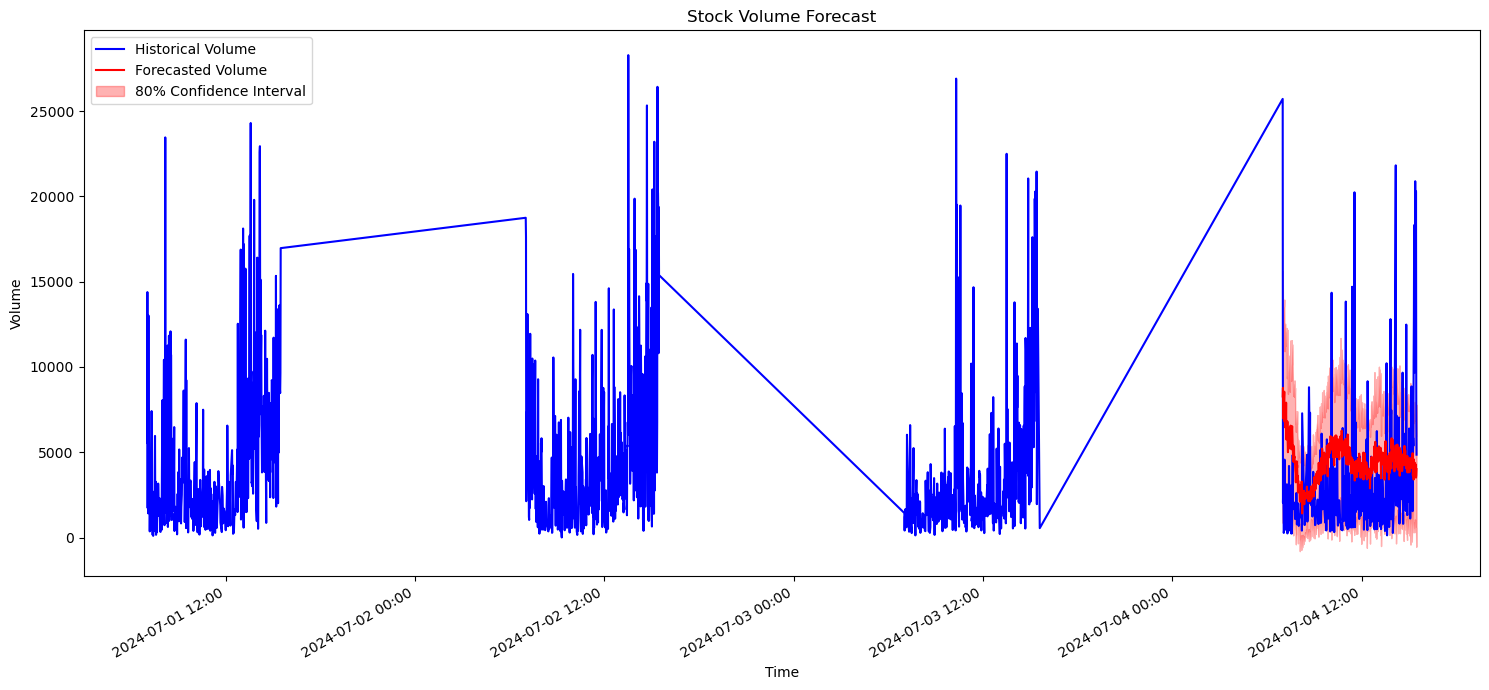

In [139]:
# Display the forecasted volume with comparison of historical volume
forecast = response['predictions'][0]
mean_forecast = forecast['mean']
mean_forecast = mean_forecast[:int(prediction_length)]

forecast_start = date_object
forecast_index = pd.date_range(start=forecast_start, periods=len(mean_forecast), freq='T')

# Create a chart
plt.figure(figsize=(15, 7))

# Plot historical data
full_date_object = date_object + timedelta(minutes=prediction_length)
df_full_history = ULVR[ULVR['timestamp'] < full_date_object]

plt.plot(df_full_history['timestamp'], df_full_history['volume'], label='Historical Volume', color='blue')

# Plot forecasted data
plt.plot(forecast_index, mean_forecast, label='Forecasted Volume', color='red')

# Plot confidence interval
plt.fill_between(forecast_index, 
                 forecast['quantiles'][low_percentile][:int(prediction_length)], 
                 forecast['quantiles'][high_percentile][:int(prediction_length)], 
                 color='red', alpha=0.3, label='80% Confidence Interval')

plt.title('Stock Volume Forecast')
plt.xlabel('Time')
plt.ylabel('Volume')
plt.legend()

# Rotate and align the tick labels so they look better
plt.gcf().autofmt_xdate()

# Use a more precise date string for the x axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))

plt.tight_layout()
plt.savefig('chart/volume_forecast.png')
plt.show()